## Загрузка необходимых модулей

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Часть I
* Загрузка тренировочного датасета
* Анализ данных
* Исправление данных

In [83]:
df = pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [84]:
# Выбор и исправление явно неверных данных
df.loc[df['Rooms']==19,'Rooms']=1
df.loc[df['Rooms']==10,'Rooms']=2
df.loc[df['Rooms']==6,'Rooms']=2
df.loc[(df['Rooms']==5) & (df['Square']<50),'Rooms']=2
for i in df.loc[(df['Square']>400),'Square']:
    df.loc[(df['Square']==i),'Square']=i/10
for i in df.loc[(df['LifeSquare']>400),'LifeSquare']:
    df.loc[(df['LifeSquare']==i),'LifeSquare']=i/10
for i in df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['LifeSquare']),'KitchenSquare']:
    df.loc[(df['KitchenSquare']==i),'KitchenSquare']=i/10
for i in df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['Square']-df['Square']/10),'KitchenSquare']:
    df.loc[(df['KitchenSquare']==i),'KitchenSquare']=i/10
for i in df.loc[(df['KitchenSquare']>25)& (df['Square']<100),'KitchenSquare']:
    df.loc[(df['KitchenSquare']==i),'KitchenSquare']=i%10+10
for i in df.loc[(df['Floor']>df['HouseFloor']) & (df['HouseFloor']==0),'Floor']:
    df.loc[(df['Floor']==i),'HouseFloor']=i
df.loc[df['Floor']>df['HouseFloor'],'Floor'] = df.loc[:,'Floor'].quantile(0.5)
df.loc[df['Floor']>df['HouseFloor'],'HouseFloor'] = df.loc[:,'HouseFloor'].quantile(0.5)

for i in df.loc[df['LifeSquare']<1,'LifeSquare']:
    df.loc[(df['LifeSquare']==i),'LifeSquare']=i*100
for i in df.loc[df['LifeSquare']<10,'LifeSquare']:
    df.loc[(df['LifeSquare']==i),'LifeSquare']=i*10
for i in df.loc[df['Square']<1,'Square']:
    df.loc[(df['Square']==i),'Square']=i*100
for i in df.loc[df['Square']<10,'Square']:
    df.loc[(df['Square']==i),'Square']=i*10
for i in df.loc[df['KitchenSquare']<1,'KitchenSquare']:
    df.loc[(df['KitchenSquare']==i),'KitchenSquare']=i*100
for i in df.loc[df['KitchenSquare']<2,'KitchenSquare']:
    df.loc[(df['KitchenSquare']==i),'KitchenSquare']=i*10
    
for i in df.loc[(df['LifeSquare']>200) & (df['Square']<100),'LifeSquare']:
    df.loc[(df['LifeSquare']==i),'LifeSquare']=i/10
for i in df.loc[df['LifeSquare']>df['Square'],'Id']:
    n=df.loc[df['Id']==i,'LifeSquare']
    m=df.loc[df['Id']==i,'Square']
    df.loc[df['Id']==i,'LifeSquare']=m
    df.loc[df['Id']==i,'Square']=n

In [85]:
# берем средние значения LifeSquare по каждому району - и используем их для заполнения пропущенных данных
df['LifeSquare']=df['LifeSquare'].fillna(df.groupby('Rooms')['LifeSquare'].transform('mean'))

In [86]:
# Исправление дат постройки
df.loc[df['HouseYear']==20052011,'HouseYear'] = 2011 # какую из двух пытались на самом деле ввести понять невозможно; просто выбираем одну из двух
df.loc[df['HouseYear']==4968,'HouseYear'] = 1968 # была явная ошибка ввода: вместо '1' ввели '4'

In [87]:
# Столбцы Ecology_3, Ecology_2, Shops_2 имеют только 2 возможных значения, поэтому делать преобразование с помощью функции dummies нет смысла
# Вместо этого примем, что часть значений A / B принимает значения 1/0/-1. Основание выбора соответствующих значений - графический анализ;
# целью преобразования является создание специальной шкалы, рост оценки по которой соответсвовал бы росту цены.
df.loc[df['Ecology_3']=='A','Ecology_3']=0
df.loc[df['Ecology_3']=='B','Ecology_3']=-1
df.loc[df['Ecology_2']=='A','Ecology_2']=0
df.loc[df['Ecology_2']=='B','Ecology_2']=-1
df.loc[df['Shops_2']=='A','Shops_2']=0
df.loc[df['Shops_2']=='B','Shops_2']=1 #

In [88]:
# Шкалирование данных; на дальнейших этапах будут проводиться разные преобразования;
# чтобы разный масштаб значений разных параметров не влиял на результаты - сразу выполним масштабирование
data_scaler = MinMaxScaler(copy = False)
# в первом (индекс = 0) столбце содержится поле Id; его масштабировать не нужно
df_scaled = pd.DataFrame(data_scaler.fit_transform(df.iloc[:,1:-1]),columns = df.iloc[:,1:-1].columns)
df.iloc[:,1:-1] = df_scaled

#### Обзор значений, сгруппированных по сумме 'Shops_2', 'Ecology_2', 'Ecology_3'

In [89]:
df.groupby(df['Shops_2']+df['Ecology_2']+df['Ecology_3']).mean()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0.0,8310.028360,0.255146,0.379038,0.169850,0.127044,0.182084,0.189859,0.165622,0.714774,0.156467,0.000000,0.000000,0.221015,0.174032,0.010520,0.292873,0.119400,0.088565,0.000000,192908.557092
1.0,8388.173593,0.236708,0.376718,0.154706,0.115272,0.189883,0.183947,0.160696,0.680282,0.222948,0.001585,0.000000,0.340219,0.282955,0.061812,0.226544,0.220379,0.193715,0.998415,215328.073329
2.0,8432.075419,0.319077,0.385475,0.141171,0.100460,0.174242,0.151996,0.133484,0.611097,0.507803,0.231844,0.768156,0.425600,0.281702,0.044039,0.333636,0.436220,0.159704,1.000000,232898.096708


##### Выявлены некоторые закономерности:
* Чем больше баллов (df['Shops_2']+df['Ecology_2']+df['Ecology_3']), тем больше Ecology_1.
* Больше баллов - больше цена.
* Ecology_1 может отражать "хорошие" черты квартир (раз цена увеличивается)
* Вычисенные баллы - "хорошие" (т.к. цена увеличивается)
* Самым маленьким значениям Shop_1 соответствует группа с самой низкой средней ценой.
* Прямая ("чем больше один, тем больше другой") связь с суммой баллов видна по параметру Social_1, Helthcare_2 и Shops_1

#### Т.к. качество полученной оценки достаточно хорошее (отражает связь с несколькими переменными), создается новый столбец (новые данные)

In [90]:
df['Score'] = df['Shops_2']+df['Ecology_2']+df['Ecology_3']

#### Визуальное представление связи между новым параметром и имеющимися данными

* Цена

<BarContainer object of 3 artists>

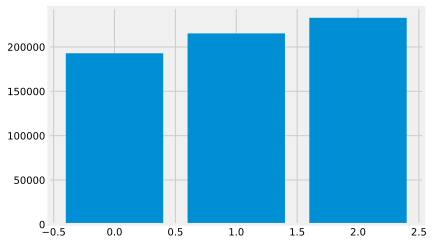

In [91]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Price'])

* Social_1

<BarContainer object of 3 artists>

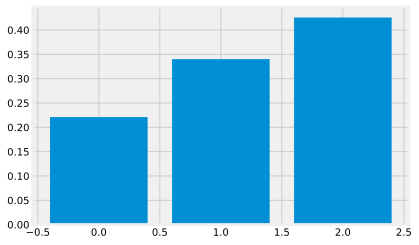

In [92]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Social_1'])

* Helthcare_2

<BarContainer object of 3 artists>

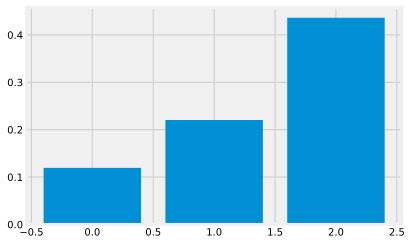

In [93]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Helthcare_2'])

* Shops_1

<BarContainer object of 3 artists>

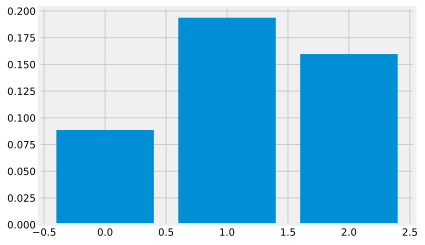

In [94]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Shops_1'])

* Ecology_1

<BarContainer object of 3 artists>

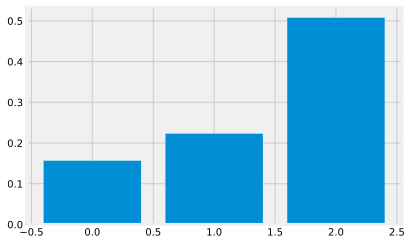

In [95]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Ecology_1'])

#### Для упрощения работы с данными можно разбить их на группы: низкие, средние, высокие и очень высокие значения.
##### Границы значений подбираются индивидуально, по графику и по значениям np.percentile.

* Группируем данные по ценам (сгруппировать почти невозможно, т.к. цены почти наверняка разные);
* Строим графики распределения полученных групп по большинству параметров, выявляя нормально распределенные или четко сгруппированные
* Всего проанализировано 14 признаков, выбрано к использованию 13 (исключен Social_3, т.к. по графику невозможно вычленить различные группы квартир)

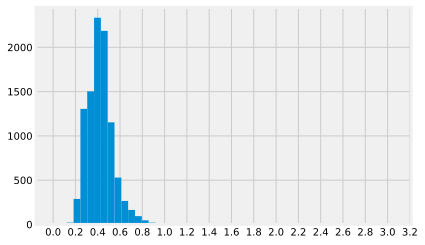

In [145]:
fig, ax = plt.subplots()
ax.hist(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'],bins=50)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

In [144]:
np.percentile(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'], [0, 5, 40, 75, 95, 100])

array([0.        , 0.25956905, 0.39067871, 0.48495635, 0.64406181,
       3.05881534])

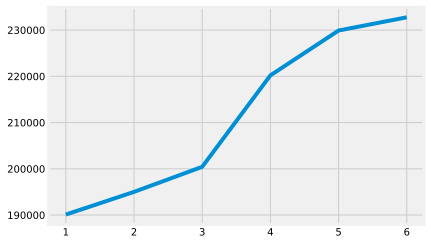

In [156]:
x0=np.percentile(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'], [0, 5, 75, 95, 100])

df['Square_Rooms_group']=''
for i,item in enumerate(df['Square']/df['Rooms']):
    if item<x0[1]:
        df.loc[df.index==i,'Square_Rooms_group']=1
    elif item>=x0[1] and item<x0[2]:
        df.loc[df.index==i,'Square_Rooms_group']=4
    elif item>=x0[2] and item<x0[3]:
        df.loc[df.index==i,'Square_Rooms_group']=2
    elif item>=x0[3] and item<x0[4]:
        df.loc[df.index==i,'Square_Rooms_group']=5
    elif item>=x0[4]:
        df.loc[df.index==i,'Square_Rooms_group']=6
df.loc[df['Rooms']==0,'Square_Rooms_group']=3
df2 = df.groupby('Square_Rooms_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

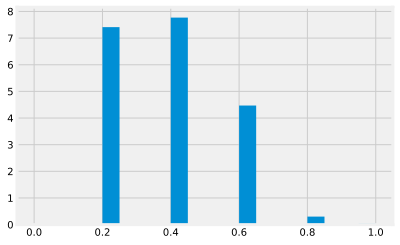

In [99]:
df1 = df.groupby('Price').mean()
plt.hist(df1.sort_values('Rooms')['Rooms'],bins=20,density=True)
plt.show()

In [100]:
np.percentile(df['Rooms'], [0, 25, 80, 98.5, 100])

array([0. , 0.2, 0.6, 0.8, 1. ])

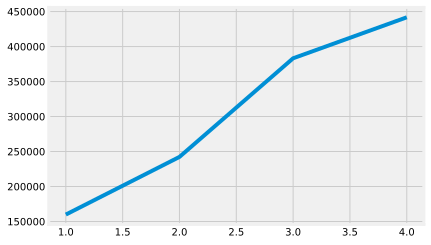

In [201]:
x1=np.percentile(df['Rooms'], [0, 25, 80, 98.5, 100])
df['Rooms_group']=''
for i,item in enumerate(df['Rooms']):
    if item<=x1[1]:
        df.loc[df.index==i,'Rooms_group']=1
    elif item>x1[1] and item<=x1[2]:
        df.loc[df.index==i,'Rooms_group']=2
    elif item>x1[2] and item<=x1[3]:
        df.loc[df.index==i,'Rooms_group']=3
    elif item>x1[3]:
        df.loc[df.index==i,'Rooms_group']=4
df.head()

df2 = df.groupby('Rooms_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

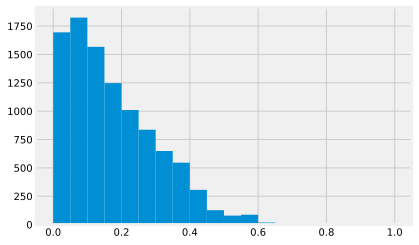

In [102]:
df1 = df.groupby('Price').mean()
plt.hist(df1.sort_values('Floor')['Floor'],bins=20)
plt.show()

In [212]:
np.percentile(df['Floor'], [0, 28, 75, 98.5, 100])

array([0.        , 0.09756098, 0.2195122 , 0.51219512, 1.        ])

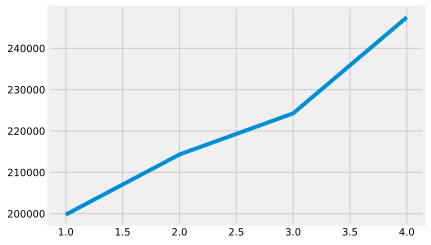

In [217]:
x2=np.percentile(df['Floor'], [0, 30, 80, 95, 100])
df['Floor_group']=''
for i,item in enumerate(df['Floor']):
    if item<x2[1]:
        df.loc[df.index==i,'Floor_group']=1
    elif item>=x2[1] and item<x2[2]:
        df.loc[df.index==i,'Floor_group']=2
    elif item>=x2[2] and item<x2[3]:
        df.loc[df.index==i,'Floor_group']=3
    elif item>=x2[3]:
        df.loc[df.index==i,'Floor_group']=4
df.head()

df2 = df.groupby('Floor_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

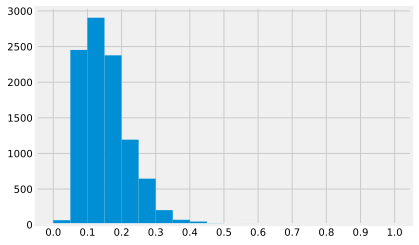

In [105]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('Square')['Square'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [106]:
np.percentile(df['Square'], [0, 1, 50, 90, 100])

array([0.        , 0.05513986, 0.14141291, 0.25020952, 1.        ])

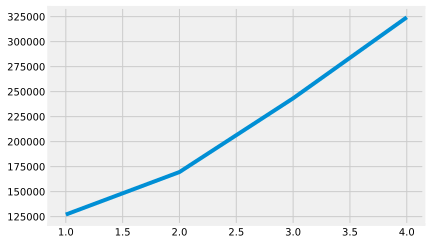

In [159]:
x3=np.percentile(df['Square'], [0, 1, 50, 90, 100])
df['Square_group']=''
for i,item in enumerate(df['Square']):
    if item<x3[1]:
        df.loc[df.index==i,'Square_group']=1
    elif item>=x3[1] and item<x3[2]:
        df.loc[df.index==i,'Square_group']=2
    elif item>=x3[2] and item<x3[3]:
        df.loc[df.index==i,'Square_group']=3
    elif item>=x3[3]:
        df.loc[df.index==i,'Square_group']=4
df.head()
df2 = df.groupby('Square_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

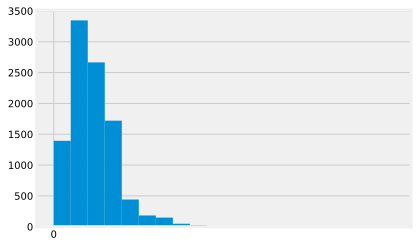

In [108]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('LifeSquare')['LifeSquare'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show()

In [109]:
np.percentile(df['LifeSquare'], [0, 8, 80, 90, 100])

array([0.        , 0.0430056 , 0.16438082, 0.18903717, 1.        ])

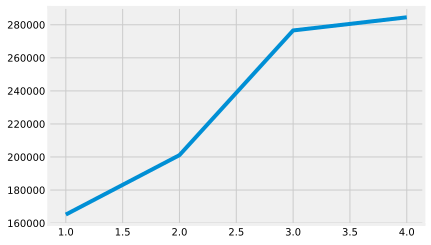

In [160]:
x4=np.percentile(df['LifeSquare'], [0, 8, 80, 90, 100])
df['LifeSquare_group']=''
for i,item in enumerate(df['LifeSquare']):
    if item<x4[1]:
        df.loc[df.index==i,'LifeSquare_group']=1
    elif item>=x4[1] and item<x4[2]:
        df.loc[df.index==i,'LifeSquare_group']=2
    elif item>=x4[2] and item<x4[3]:
        df.loc[df.index==i,'LifeSquare_group']=3
    elif item>=x4[3]:
        df.loc[df.index==i,'LifeSquare_group']=4
df.head()


df2 = df.groupby('LifeSquare_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

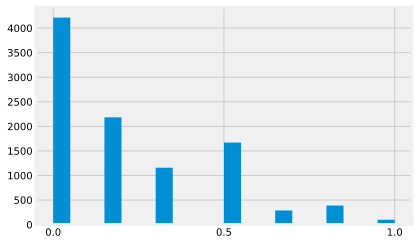

In [111]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('Helthcare_2')['Helthcare_2'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.show()

In [268]:
np.percentile(df['Helthcare_2'], [0, 50, 75, 90, 100])

array([0.        , 0.16666667, 0.33333333, 0.5       , 1.        ])

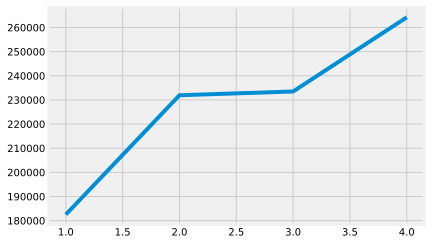

In [161]:
x5=np.percentile(df['Helthcare_2'], [0, 50, 75, 90, 100])
df['Helthcare_2_group']=''
for i,item in enumerate(df['Helthcare_2']):
    if item<x5[1]:
        df.loc[df.index==i,'Helthcare_2_group']=1
    elif item>=x5[1] and item<=x5[2]:
        df.loc[df.index==i,'Helthcare_2_group']=3
    elif item>x5[2] and item<=x5[3]:
        df.loc[df.index==i,'Helthcare_2_group']=2
    elif item>x5[3]:
        df.loc[df.index==i,'Helthcare_2_group']=4
df.head()


df2 = df.groupby('Helthcare_2_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

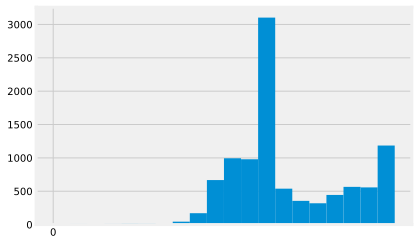

In [114]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('HouseYear')['HouseYear'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show()

In [115]:
np.percentile(df['HouseYear'], [0, 10, 60, 75, 100])

array([0.        , 0.5       , 0.64545455, 0.82727273, 1.        ])

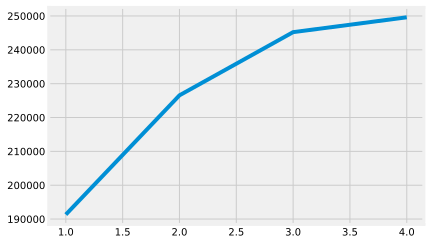

In [162]:
x6=np.percentile(df['HouseYear'], [0, 10, 60, 75, 100])
df['HouseYear_group']=''
for i,item in enumerate(df['HouseYear']):
    if item<x6[1]:
        df.loc[df.index==i,'HouseYear_group']=4
    elif item>=x6[1] and item<x6[2]:
        df.loc[df.index==i,'HouseYear_group']=1
    elif item>=x6[2] and item<x6[3]:
        df.loc[df.index==i,'HouseYear_group']=3
    elif item>=x6[3]:
        df.loc[df.index==i,'HouseYear_group']=2
df.head()


df2 = df.groupby('HouseYear_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

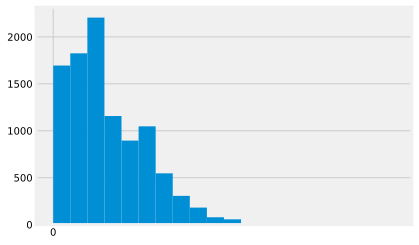

In [117]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['HouseFloor'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

In [118]:
np.percentile(df['HouseFloor'], [0, 25, 50, 88, 100])

array([0.        , 0.06382979, 0.12765957, 0.29787234, 1.        ])

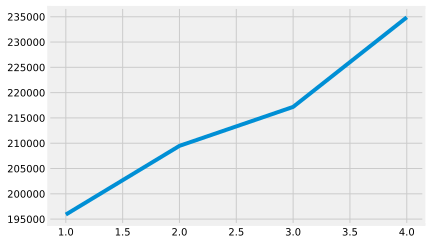

In [119]:
x7=np.percentile(df['HouseFloor'], [0, 25, 50, 88, 100])
df['HouseFloor_group']=''
for i,item in enumerate(df['HouseFloor']):
    if item<x7[1]:
        df.loc[df.index==i,'HouseFloor_group']=1
    elif item>=x7[1] and item<x7[2]:
        df.loc[df.index==i,'HouseFloor_group']=2
    elif item>=x7[2] and item<x7[3]:
        df.loc[df.index==i,'HouseFloor_group']=3
    elif item>=x7[3]:
        df.loc[df.index==i,'HouseFloor_group']=4
df.head()


df2 = df.groupby('HouseFloor_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

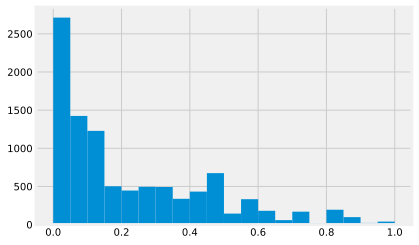

In [120]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Ecology_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [234]:
np.percentile(df['Ecology_1'], [0, 15, 52, 96.4, 100])

array([0.        , 0.01364776, 0.14520701, 0.78042143, 1.        ])

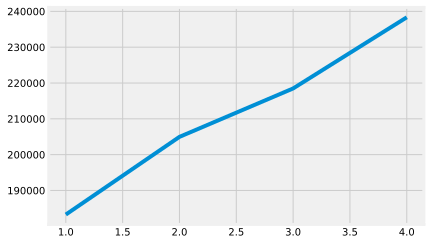

In [235]:
x8=np.percentile(df['Ecology_1'], [0, 15, 55, 96.4, 100])
df['Ecology_1_group']=''
for i,item in enumerate(df['Ecology_1']):
    if item<x8[1]:
        df.loc[df.index==i,'Ecology_1_group']=4
    elif item>=x8[1] and item<x8[2]:
        df.loc[df.index==i,'Ecology_1_group']=2
    elif item>=x8[2] and item<x8[3]:
        df.loc[df.index==i,'Ecology_1_group']=3
    elif item>=x8[3]:
        df.loc[df.index==i,'Ecology_1_group']=1
df.head()


df2 = df.groupby('Ecology_1_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

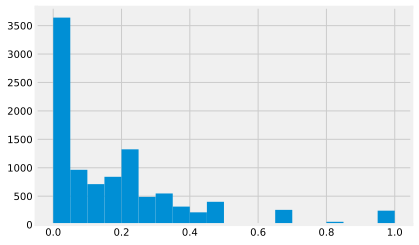

In [123]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Shops_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [124]:
np.percentile(df['Shops_1'], [0, 25, 75, 85, 100])

array([0.        , 0.04347826, 0.26086957, 0.43478261, 1.        ])

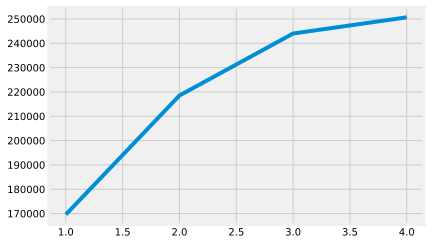

In [164]:
x9=np.percentile(df['Shops_1'], [0, 25, 75, 85, 100])
df['Shops_1_group']=''
for i,item in enumerate(df['Shops_1']):
    if item<x9[1]:
        df.loc[df.index==i,'Shops_1_group']=1
    elif item>=x9[1] and item<x9[2]:
        df.loc[df.index==i,'Shops_1_group']=2
    elif item>=x9[2] and item<x9[3]:
        df.loc[df.index==i,'Shops_1_group']=4
    elif item>=x9[3]:
        df.loc[df.index==i,'Shops_1_group']=3
df.head()


df2 = df.groupby('Shops_1_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

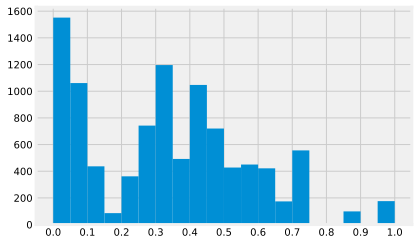

In [173]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [187]:
np.percentile(df['Social_1'], [0, 20,27, 38, 80, 100])

array([0.        , 0.06756757, 0.12162162, 0.28378378, 0.52702703,
       1.        ])

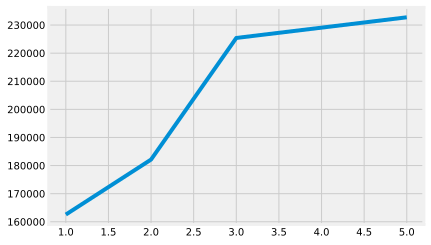

In [188]:
x10=np.percentile(df['Social_1'], [0, 25,27, 38, 80, 100])
df['Social_1_group']=''
for i,item in enumerate(df['Social_1']):
    if item<x10[1]:
        df.loc[df.index==i,'Social_1_group']=1
    elif item>=x10[1] and item<x10[2]:
        df.loc[df.index==i,'Social_1_group']=2
    elif item>=x10[2] and item<x10[3]:
        df.loc[df.index==i,'Social_1_group']=3
    elif item>=x10[2] and item<x10[3]:
        df.loc[df.index==i,'Social_1_group']=4
    elif item>=x10[3]:
        df.loc[df.index==i,'Social_1_group']=5
df.head()


df2 = df.groupby('Social_1_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

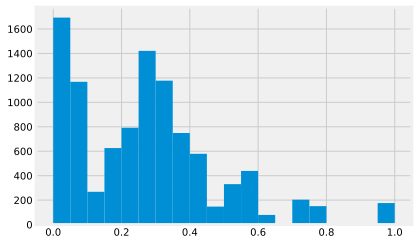

In [129]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_2'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [197]:
np.percentile(df['Social_2'], [0, 35, 70, 94, 100])

array([0.        , 0.18112609, 0.34607454, 0.6381179 , 1.        ])

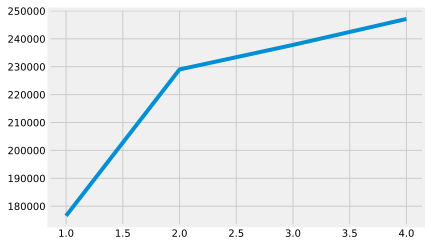

In [198]:
x11=np.percentile(df['Social_2'], [0, 35, 70, 94, 100])
df['Social_2_group']=''
for i,item in enumerate(df['Social_2']):
    if item<x11[1]:
        df.loc[df.index==i,'Social_2_group']=1
    elif item>=x11[1] and item<x11[2]:
        df.loc[df.index==i,'Social_2_group']=2
    elif item>=x11[2] and item<x11[3]:
        df.loc[df.index==i,'Social_2_group']=3
    elif item>=x11[3]:
        df.loc[df.index==i,'Social_2_group']=4
df.head()


df2 = df.groupby('Social_2_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

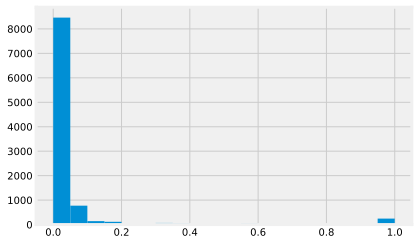

In [132]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_3'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

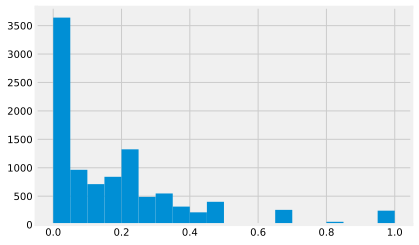

In [133]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Shops_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [134]:
np.percentile(df['Shops_1'], [0, 36.4052, 80, 94.471, 100])

array([0.        , 0.05025861, 0.30434783, 0.50526783, 1.        ])

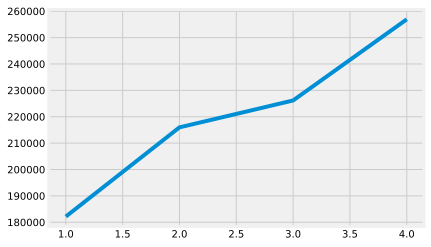

In [135]:
x12=np.percentile(df['Shops_1'], [0, 36.4052, 80, 94.471, 100])
df['Shops_1_group']=''
for i,item in enumerate(df['Shops_1']):
    if item<x12[1]:
        df.loc[df.index==i,'Shops_1_group']=1
    elif item>=x12[1] and item<x12[2]:
        df.loc[df.index==i,'Shops_1_group']=3
    elif item>=x12[2] and item<x12[3]:
        df.loc[df.index==i,'Shops_1_group']=4
    elif item>=x12[3]:
        df.loc[df.index==i,'Shops_1_group']=2
df.head()


df2 = df.groupby('Shops_1_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

#### В результате проведенной генерации данных, получаем суммарную оценку по данным параметра

In [236]:
df['Score_2']=df['Square_Rooms_group']+df['Shops_1_group']+df['Helthcare_2_group']+df['HouseYear_group']+df['Rooms_group']+df['Floor_group']+df['Square_group']+df['LifeSquare_group']+df['HouseFloor_group']+df['Ecology_1_group']+df['Shops_1_group']+df['Social_2_group']+df['Social_1_group']

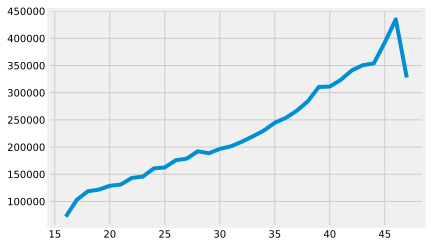

In [237]:
plt.plot(df.groupby('Score_2').mean().index,df.groupby('Score_2').mean()['Price'])

### В результате преобразований получен dataframe со следующими характеристиками

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
Id                    10000 non-null int64
DistrictId            10000 non-null float64
Rooms                 10000 non-null float64
Square                10000 non-null float64
LifeSquare            10000 non-null float64
KitchenSquare         10000 non-null float64
Floor                 10000 non-null float64
HouseFloor            10000 non-null float64
HouseYear             10000 non-null float64
Ecology_1             10000 non-null float64
Ecology_2             10000 non-null float64
Ecology_3             10000 non-null float64
Social_1              10000 non-null float64
Social_2              10000 non-null float64
Social_3              10000 non-null float64
Clusters              10000 non-null int32
Healthcare_1          5202 non-null float64
Helthcare_2           10000 non-null float64
Shops_1               10000 non-null float64
Shops_2               10000 non-null float

In [58]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_group,LifeSquare_group,Helthcare_2_group,HouseYear_group,HouseFloor_group,Ecology_1_group,Shops_1_group,Social_1_group,Social_2_group,Score_2
0,14038,0.167464,0.4,0.123212,0.084780,0.142857,0.146341,0.127660,0.536364,0.170618,...,2,2,1,1,3,3,4,2,3,32
1,15053,0.196172,0.6,0.191387,0.132248,0.190476,0.146341,0.127660,0.618182,0.000134,...,3,2,3,1,3,4,2,3,2,32
2,4765,0.253589,0.4,0.111528,0.083683,0.000000,0.170732,0.148936,0.527273,0.095115,...,2,2,3,1,3,4,3,2,3,33
3,5809,0.277512,0.4,0.143898,0.189003,0.214286,0.170732,0.148936,0.609091,0.839074,...,3,3,1,1,3,1,3,4,3,32
4,10783,0.473684,0.2,0.091122,0.059420,0.166667,0.243902,0.212766,0.600000,0.023644,...,2,2,3,1,3,4,3,2,3,34


#### Просмотр параметров (features), которые будут использованы для анализа

In [249]:
features = list(df.columns)
print(features)

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Clusters', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Score', 'Square_Rooms_group', 'Rooms_group', 'Floor_group', 'Square_group', 'LifeSquare_group', 'Helthcare_2_group', 'HouseYear_group', 'HouseFloor_group', 'Ecology_1_group', 'Shops_1_group', 'Social_1_group', 'Social_2_group', 'Score_2']


#### Удаление тех, которые уже учтены в Score и Score_2, а также Id и Price

In [250]:
features = list(df.columns)
features.remove('Id')
features.remove('Price')
features.remove('Healthcare_1')
features.remove('Rooms_group')
features.remove('Floor_group')
features.remove('Square_group')
features.remove('Square_Rooms_group')
features.remove('Helthcare_2_group')
features.remove('LifeSquare_group')
features.remove('HouseYear_group')
features.remove('HouseFloor_group')
features.remove('Ecology_1_group')
features.remove('Shops_1_group')
features.remove('Ecology_2')
features.remove('Ecology_3')
features.remove('Shops_2')
features.remove('Social_1_group')
features.remove('Social_2_group')

print(features)

['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Clusters', 'Helthcare_2', 'Shops_1', 'Score', 'Score_2']


#### Использование Price в качестве целевой переменной
#### Создание датафрейма с выбранными параметрами на основе списка features

In [251]:
target = df['Price']
data_full = df[features].copy()

#### Группировка данных с использованием KMeans

In [253]:
kmeans_model = KMeans(random_state=881)
kmeans_scaler = MinMaxScaler(copy = False)
df_kmeans = kmeans_scaler.fit_transform(data_full[['DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1']])
kmeans_labels = kmeans_model.fit_predict(df_kmeans)

data_full.insert(16,'Clusters',kmeans_labels)

#### В результате использования KMeans получилось 8 кластеров, к которым относятся квартиры с различными комбинациями 6 параметров ('DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1'); средний уровень цен в них разный, но есть и довольно близкие кластеры по ценовой характеристике, поэтому было бы сложно отнести ту или иную квартиру к определенному кластеру без применения алгоритма.

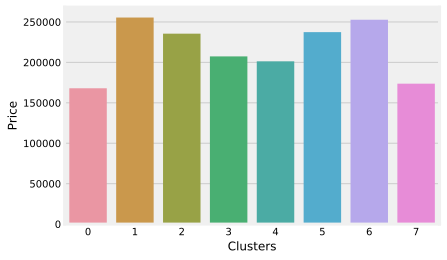

In [255]:
df.insert(15,'Clusters',kmeans_labels)
sns.barplot(df.groupby('Clusters').mean().index,df.groupby('Clusters').mean()['Price'])
plt.show()

In [256]:
data_full.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Clusters,Helthcare_2,Shops_1,Score,Score_2
0,0.167464,0.4,0.123212,0.084780,0.142857,0.146341,0.127660,0.536364,0.170618,0.445946,0.412794,0.035461,2,0.000000,0.478261,1.0,33
1,0.196172,0.6,0.191387,0.132248,0.190476,0.146341,0.127660,0.618182,0.000134,0.621622,0.536135,0.007092,2,0.166667,0.695652,1.0,38
2,0.253589,0.4,0.111528,0.083683,0.000000,0.170732,0.148936,0.527273,0.095115,0.459459,0.401322,0.000000,2,0.166667,0.130435,1.0,33
3,0.277512,0.4,0.143898,0.189003,0.214286,0.170732,0.148936,0.609091,0.839074,0.310811,0.294317,0.021277,4,0.000000,0.217391,1.0,31
4,0.473684,0.2,0.091122,0.059420,0.166667,0.243902,0.212766,0.600000,0.023644,0.472973,0.296484,0.007092,6,0.333333,0.173913,1.0,31


#### К уже имеющемуся списку полей для анализа (features) нужно добавить поле 'Clusters' и удалить 'Social_2' (т.к. ранее на графике было показано, что его сложно использовать для дифференциации групп квартир

In [257]:
features.append('Clusters')
features.remove('Social_2')
target = df['Price']
data_full = df[features].copy()

#### Все готово для начала процесса обучения модели

In [258]:
#### Используем minmaxscaler чтобы убедиться в том, что данные масштабированы, т.к. много изменений было сделано в процессе подготовки данных
scaler = MinMaxScaler(copy = False)
x_train, x_test, y_train, y_test = train_test_split(data_full, target, shuffle = True, test_size = 0.3, random_state = 90)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
#### Параметры для обучения модели были получены с использованием GridSearchCV; оставлено название gs_cv.
gs_cv = GradientBoostingRegressor(n_estimators=5000,learning_rate=0.01,max_depth=4,min_samples_leaf=2,min_samples_split=3,subsample=0.6)
gs_cv.fit(x_train_scaled,y_train)
y_train_hat=gs_cv.predict(x_train_scaled)
y_hat=gs_cv.predict(x_test_scaled)

In [259]:
# Визуализация результатов предсказаний: сравнение с реальными данными.
def evaluate_preds(true_values,pred_values):
    print('R2\t'+str(round(r2_score(true_values,pred_values),3))+'\n'+
          'MAE\t'+str(round(mean_absolute_error(true_values,pred_values),3))+'\n'+
          'MSE\t'+str(round(mean_squared_error(true_values,pred_values),3)))
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=pred_values,y=true_values)
    plt.xlabel('Рассчитанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Результаты расчета: сравнение с реальными данными')
    plt.show()

#### Просмотр насколько хорошо обучена модель на тренировочных данных

R2	0.923
MAE	17703.148
MSE	676904218.223


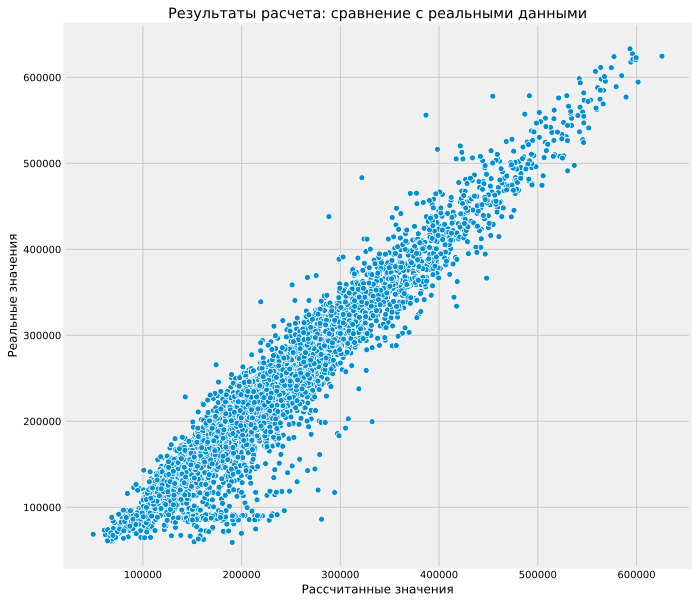

In [260]:
y_train_hat=gs_cv.predict(x_train_scaled)
evaluate_preds(y_train,y_train_hat)

#### Просмотр результатов работы модели на тестовой выборки, выделенной из уже имеющихся данных

R2	0.722
MAE	28473.794
MSE	2324916310.198


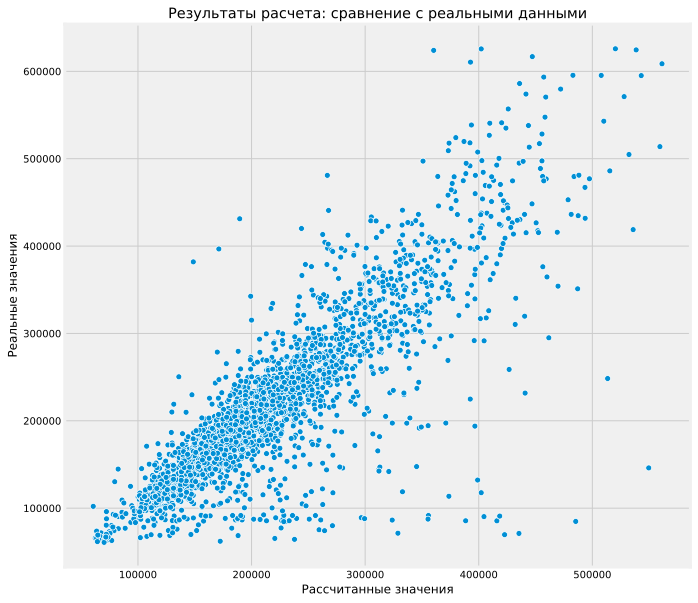

In [261]:
y_hat=gs_cv.predict(x_test_scaled)
evaluate_preds(y_test,y_hat)

# Часть 2
## Прогнозирование цены на тестовых данных

In [269]:
df_to_test = pd.read_csv('test.csv')
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [270]:
df_to_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Проведение тех же преобразований, что и с тренировочной базой данных

In [271]:
# Проведение тех же преобразований, что и с тренировочной базой данных
df_to_test.loc[df_to_test['Rooms']==19,'Rooms']=1
df_to_test.loc[df_to_test['Rooms']==10,'Rooms']=2
df_to_test.loc[df_to_test['Rooms']==6,'Rooms']=2
df_to_test.loc[(df_to_test['Rooms']==5) & (df_to_test['Square']<50),:]=2
for i in df_to_test.loc[(df_to_test['Square']>400),'Square']:
    df_to_test.loc[(df_to_test['Square']==i),'Square']=i/10
for i in df_to_test.loc[(df_to_test['LifeSquare']>400),'LifeSquare']:
    df_to_test.loc[(df_to_test['LifeSquare']==i),'LifeSquare']=i/10
for i in df_to_test.loc[(df_to_test['KitchenSquare']>25) & (df_to_test['KitchenSquare']>df_to_test['LifeSquare']),'KitchenSquare']:
    df_to_test.loc[(df_to_test['KitchenSquare']==i),'KitchenSquare']=i/10
for i in df_to_test.loc[(df_to_test['KitchenSquare']>25) & (df_to_test['KitchenSquare']>df_to_test['Square']-df_to_test['Square']/10),'KitchenSquare']:
    df_to_test.loc[(df_to_test['KitchenSquare']==i),'KitchenSquare']=i/10
for i in df_to_test.loc[(df_to_test['KitchenSquare']>25)& (df_to_test['Square']<100),'KitchenSquare']:
    df_to_test.loc[(df_to_test['KitchenSquare']==i),'KitchenSquare']=i%10+10
for i in df_to_test.loc[(df_to_test['Floor']>df_to_test['HouseFloor']) & (df_to_test['HouseFloor']==0),'Floor']:
    df_to_test.loc[(df_to_test['Floor']==i),'HouseFloor']=i
df_to_test.loc[df_to_test['Floor']>df_to_test['HouseFloor'],'Floor'] = df_to_test.loc[:,'Floor'].quantile(0.5)
df_to_test.loc[df_to_test['Floor']>df_to_test['HouseFloor'],'HouseFloor'] = df_to_test.loc[:,'HouseFloor'].quantile(0.5)

for i in df_to_test.loc[df_to_test['LifeSquare']<1,'LifeSquare']:
    df_to_test.loc[(df_to_test['LifeSquare']==i),'LifeSquare']=i*100
for i in df_to_test.loc[df_to_test['LifeSquare']<10,'LifeSquare']:
    df_to_test.loc[(df_to_test['LifeSquare']==i),'LifeSquare']=i*10
for i in df_to_test.loc[df_to_test['Square']<1,'Square']:
    df_to_test.loc[(df_to_test['Square']==i),'Square']=i*100
for i in df_to_test.loc[df_to_test['Square']<10,'Square']:
    df_to_test.loc[(df_to_test['Square']==i),'Square']=i*10
for i in df_to_test.loc[df_to_test['KitchenSquare']<1,'KitchenSquare']:
    df_to_test.loc[(df_to_test['KitchenSquare']==i),'KitchenSquare']=i*100
for i in df_to_test.loc[df_to_test['KitchenSquare']<2,'KitchenSquare']:
    df_to_test.loc[(df_to_test['KitchenSquare']==i),'KitchenSquare']=i*10
    
for i in df_to_test.loc[(df_to_test['LifeSquare']>200) & (df_to_test['Square']<100),'LifeSquare']:
    df_to_test.loc[(df_to_test['LifeSquare']==i),'LifeSquare']=i/10
for i in df_to_test.loc[df_to_test['LifeSquare']>df_to_test['Square'],'Id']:
    n=df_to_test.loc[df_to_test['Id']==i,'LifeSquare']
    m=df_to_test.loc[df_to_test['Id']==i,'Square']
    df_to_test.loc[df_to_test['Id']==i,'LifeSquare']=m
    df_to_test.loc[df_to_test['Id']==i,'Square']=n

df_to_test['LifeSquare']=df_to_test['LifeSquare'].fillna(df_to_test.groupby('Rooms')['LifeSquare'].transform('mean'))

df_to_test.loc[df_to_test['Ecology_3']=='A','Ecology_3']=0
df_to_test.loc[df_to_test['Ecology_3']=='B','Ecology_3']=-1
df_to_test.loc[df_to_test['Ecology_2']=='A','Ecology_2']=0
df_to_test.loc[df_to_test['Ecology_2']=='B','Ecology_2']=-1
df_to_test.loc[df_to_test['Shops_2']=='A','Shops_2']=0
df_to_test.loc[df_to_test['Shops_2']=='B','Shops_2']=1 #-1, т.к. при попытке объяснить значения получается несколько другая логика; таким образом, значение -1 получено при простой попытке объяснить значения признаков
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6.0,6.0,1972,0.310199,-1,-1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,36.543857,10.0,6.0,6.0,1977,0.075779,-1,-1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,15.948246,13.597819,12.0,2.0,2.0,1909,0.000000,-1,-1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,-1,-1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,10.0,17.0,17.0,2017,0.072158,-1,-1,2,629,1,NaN,0,0,0


#### Масштабирование данных с помощью уже имеющейся модели data_scaler (создана в начале исследования)

In [272]:
df_scaled = pd.DataFrame(data_scaler.transform(df_to_test.iloc[:,1:]),columns = df_to_test.iloc[:,1:].columns)
df_to_test.iloc[:,1:] = df_scaled
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,0.277512,0.4,0.130533,0.102636,0.142857,0.121951,0.106383,0.563636,0.594403,0.0,0.0,0.148649,0.136400,0.007092,NaN,0.000000,0.000000,1.0
1,15856,0.354067,0.4,0.205172,0.116559,0.238095,0.121951,0.106383,0.609091,0.145207,0.0,0.0,0.081081,0.067090,0.021277,NaN,0.000000,0.086957,1.0
2,5480,0.909091,0.2,-0.000157,0.013869,0.285714,0.024390,0.021277,-0.009091,0.000000,0.0,0.0,0.405405,0.389638,0.617021,0.969684,0.833333,0.217391,1.0
3,15664,0.224880,0.4,0.219743,0.185465,0.214286,0.512195,0.446809,0.881818,0.195208,0.0,0.0,0.310811,0.233413,0.021277,NaN,0.500000,0.130435,1.0
4,14275,0.129187,0.2,0.121461,0.147186,0.238095,0.390244,0.340426,0.972727,0.138268,0.0,0.0,0.027027,0.024372,0.007092,NaN,0.000000,0.000000,0.0


#### Проверка заполненности всех полей

In [273]:
df_to_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null float64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null float64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null float64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null float64
Ecology_3        5000 non-null float64
Social_1         5000 non-null float64
Social_2         5000 non-null float64
Social_3         5000 non-null float64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null float64
Shops_1          5000 non-null float64
Shops_2          5000 non-null float64
dtypes: float64(18), int64(1)
memory usage: 742.3 KB


#### Генерация новых признаков (аналогично тем, что созданы для базы данных, предоставленной для обучения)

In [274]:
df_to_test['Square_Rooms_group']=''
for i,item in enumerate(df_to_test['Square']/df_to_test['Rooms']):
    if item<x0[1]:
        df_to_test.loc[df_to_test.index==i,'Square_Rooms_group']=1
    elif item>=x0[1] and item<x0[2]:
        df_to_test.loc[df_to_test.index==i,'Square_Rooms_group']=4
    elif item>=x0[2] and item<x0[3]:
        df_to_test.loc[df_to_test.index==i,'Square_Rooms_group']=2
    elif item>=x0[3] and item<x0[4]:
        df_to_test.loc[df_to_test.index==i,'Square_Rooms_group']=5
    elif item>=x0[4]:
        df_to_test.loc[df_to_test.index==i,'Square_Rooms_group']=6
df_to_test.loc[df_to_test['Rooms']==0,'Square_Rooms_group']=3

df_to_test['Rooms_group']=''
for i,item in enumerate(df_to_test['Rooms']):
    if item<=x1[1]:
        df_to_test.loc[df_to_test.index==i,'Rooms_group']=1
    elif item>x1[1] and item<=x1[2]:
        df_to_test.loc[df_to_test.index==i,'Rooms_group']=2
    elif item>x1[2] and item<=x1[3]:
        df_to_test.loc[df_to_test.index==i,'Rooms_group']=3
    elif item>x1[3]:
        df_to_test.loc[df_to_test.index==i,'Rooms_group']=4

df_to_test['Floor_group']=''
for i,item in enumerate(df_to_test['Floor']):
    if item<x2[1]:
        df_to_test.loc[df_to_test.index==i,'Floor_group']=1
    elif item>=x2[1] and item<x2[2]:
        df_to_test.loc[df_to_test.index==i,'Floor_group']=2
    elif item>=x2[2] and item<x2[3]:
        df_to_test.loc[df_to_test.index==i,'Floor_group']=3
    elif item>=x2[3]:
        df_to_test.loc[df_to_test.index==i,'Floor_group']=4

df_to_test['Square_group']=''
for i,item in enumerate(df_to_test['Square']):
    if item<x3[1]:
        df_to_test.loc[df_to_test.index==i,'Square_group']=1
    elif item>=x3[1] and item<x3[2]:
        df_to_test.loc[df_to_test.index==i,'Square_group']=2
    elif item>=x3[2] and item<x3[3]:
        df_to_test.loc[df_to_test.index==i,'Square_group']=3
    elif item>=x3[3]:
        df_to_test.loc[df_to_test.index==i,'Square_group']=4

df_to_test['LifeSquare_group']=''
for i,item in enumerate(df_to_test['LifeSquare']):
    if item<x4[1]:
        df_to_test.loc[df_to_test.index==i,'LifeSquare_group']=1
    elif item>=x4[1] and item<x4[2]:
        df_to_test.loc[df_to_test.index==i,'LifeSquare_group']=2
    elif item>=x4[2] and item<x4[3]:
        df_to_test.loc[df_to_test.index==i,'LifeSquare_group']=3
    elif item>=x4[3]:
        df_to_test.loc[df_to_test.index==i,'LifeSquare_group']=4

df_to_test['Helthcare_2_group']=''
for i,item in enumerate(df_to_test['Helthcare_2']):
    if item<x5[1]:
        df_to_test.loc[df_to_test.index==i,'Helthcare_2_group']=1
    elif item>=x5[1] and item<=x5[2]:
        df_to_test.loc[df_to_test.index==i,'Helthcare_2_group']=3
    elif item>x5[2] and item<=x5[3]:
        df_to_test.loc[df_to_test.index==i,'Helthcare_2_group']=2
    elif item>x5[3]:
        df_to_test.loc[df_to_test.index==i,'Helthcare_2_group']=4

df_to_test['HouseYear_group']=''
for i,item in enumerate(df_to_test['HouseYear']):
    if item<x6[1]:
        df_to_test.loc[df_to_test.index==i,'HouseYear_group']=4
    elif item>=x6[1] and item<x6[2]:
        df_to_test.loc[df_to_test.index==i,'HouseYear_group']=1
    elif item>=x6[2] and item<x6[3]:
        df_to_test.loc[df_to_test.index==i,'HouseYear_group']=3
    elif item>=x6[3]:
        df_to_test.loc[df_to_test.index==i,'HouseYear_group']=2

df_to_test['HouseFloor_group']=''
for i,item in enumerate(df_to_test['HouseFloor']):
    if item<x7[1]:
        df_to_test.loc[df_to_test.index==i,'HouseFloor_group']=1
    elif item>=x7[1] and item<x7[2]:
        df_to_test.loc[df_to_test.index==i,'HouseFloor_group']=2
    elif item>=x7[2] and item<x7[3]:
        df_to_test.loc[df_to_test.index==i,'HouseFloor_group']=3
    elif item>=x7[3]:
        df_to_test.loc[df_to_test.index==i,'HouseFloor_group']=4

df_to_test['Ecology_1_group']=''
for i,item in enumerate(df_to_test['Ecology_1']):
    if item<x8[1]:
        df_to_test.loc[df_to_test.index==i,'Ecology_1_group']=4
    elif item>=x8[1] and item<x8[2]:
        df_to_test.loc[df_to_test.index==i,'Ecology_1_group']=2
    elif item>=x8[2] and item<x8[3]:
        df_to_test.loc[df_to_test.index==i,'Ecology_1_group']=3
    elif item>=x8[3]:
        df_to_test.loc[df_to_test.index==i,'Ecology_1_group']=1

df_to_test['Shops_1_group']=''
for i,item in enumerate(df_to_test['Shops_1']):
    if item<x9[1]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=1
    elif item>=x9[1] and item<x9[2]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=2
    elif item>=x9[2] and item<x9[3]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=4
    elif item>=x9[3]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=3

df_to_test['Social_1_group']=''
for i,item in enumerate(df_to_test['Social_1']):
    if item<x10[1]:
        df_to_test.loc[df_to_test.index==i,'Social_1_group']=1
    elif item>=x10[1] and item<x10[2]:
        df_to_test.loc[df_to_test.index==i,'Social_1_group']=2
    elif item>=x10[2] and item<x10[3]:
        df_to_test.loc[df_to_test.index==i,'Social_1_group']=3
    elif item>=x10[2] and item<x10[3]:
        df_to_test.loc[df_to_test.index==i,'Social_1_group']=4
    elif item>=x10[3]:
        df_to_test.loc[df_to_test.index==i,'Social_1_group']=5

df_to_test['Social_2_group']=''
for i,item in enumerate(df_to_test['Social_2']):
    if item<x11[1]:
        df_to_test.loc[df_to_test.index==i,'Social_2_group']=1
    elif item>=x11[1] and item<x11[2]:
        df_to_test.loc[df_to_test.index==i,'Social_2_group']=2
    elif item>=x11[2] and item<x11[3]:
        df_to_test.loc[df_to_test.index==i,'Social_2_group']=3
    elif item>=x11[3]:
        df_to_test.loc[df_to_test.index==i,'Social_2_group']=4

df_to_test['Shops_1_group']=''
for i,item in enumerate(df_to_test['Shops_1']):
    if item<x12[1]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=1
    elif item>=x12[1] and item<x12[2]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=3
    elif item>=x12[2] and item<x12[3]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=4
    elif item>=x12[3]:
        df_to_test.loc[df_to_test.index==i,'Shops_1_group']=2

#### Определение принадлежности к ранее созданным кластерам с помощью KMeans

In [275]:
kmeans_labels_test = kmeans_model.predict(df_to_test[['DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1']])
df_to_test.insert(16,'Clusters',kmeans_labels_test)

In [276]:
df_to_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
Id                    5000 non-null int64
DistrictId            5000 non-null float64
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null float64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null float64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null float64
Ecology_3             5000 non-null float64
Social_1              5000 non-null float64
Social_2              5000 non-null float64
Social_3              5000 non-null float64
Healthcare_1          2623 non-null float64
Clusters              5000 non-null int32
Helthcare_2           5000 non-null float64
Shops_1               5000 non-null float64
Shops_2               5000 non-null float64
Square_Rooms_grou

#### Добавление оценок Score и Score_2

In [277]:
df_to_test['Score'] = df_to_test['Shops_2']+df_to_test['Ecology_2']+df_to_test['Ecology_3']
df_to_test['Score_2']=df_to_test['Square_Rooms_group']+\
df_to_test['Shops_1_group']+\
df_to_test['Helthcare_2_group']+\
df_to_test['HouseYear_group']+\
df_to_test['Rooms_group']+\
df_to_test['Floor_group']+\
df_to_test['Square_group']+\
df_to_test['LifeSquare_group']+\
df_to_test['HouseFloor_group']+\
df_to_test['Ecology_1_group']+\
df_to_test['Shops_1_group']+\
df_to_test['Social_2_group']+\
df_to_test['Social_1_group']

#### Создание окончательного датафрейма для предсказания цен

In [278]:
data_to_test = df_to_test[features].copy()

#### Использование готовой модели gs_cv для предсказания цен. Дополнительно, перед этим произведено масштабирование данных после многочисленных преобразований датафрейма

In [279]:
data_test_scaled = scaler.transform(data_to_test)
y_hat=gs_cv.predict(data_test_scaled)
df_to_test['Price'] = y_hat
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2_group,HouseYear_group,HouseFloor_group,Ecology_1_group,Shops_1_group,Social_1_group,Social_2_group,Score,Score_2,Price
0,725,0.277512,0.4,0.130533,0.102636,0.142857,0.121951,0.106383,0.563636,0.594403,...,1,1,2,3,1,3,1,1.0,25,151513.509044
1,15856,0.354067,0.4,0.205172,0.116559,0.238095,0.121951,0.106383,0.609091,0.145207,...,1,1,2,2,3,2,1,1.0,26,210154.623858
2,5480,0.909091,0.2,-0.000157,0.013869,0.285714,0.024390,0.021277,-0.009091,0.000000,...,4,4,1,4,3,5,3,1.0,32,224078.736699
3,15664,0.224880,0.4,0.219743,0.185465,0.214286,0.512195,0.446809,0.881818,0.195208,...,2,2,4,3,3,5,2,1.0,38,388910.819328
4,14275,0.129187,0.2,0.121461,0.147186,0.238095,0.390244,0.340426,0.972727,0.138268,...,1,2,4,2,1,1,1,0.0,23,145514.166402


#### Сохранение результатов в файл

In [280]:
df_result_csv = df_to_test[['Id','Price']]
df_result_csv.to_csv('AndreiLipin_predictions.csv',index=False)
df_result_csv.head()

,Id,Price
0,725,151513.509044
1,15856,210154.623858
2,5480,224078.736699
3,15664,388910.819328
4,14275,145514.166402
